In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
df = pd.read_csv('Warehouse_and_Retail_Sales.csv')

df_clean = df.copy()
df_clean = df_clean.fillna(0)
df_clean = df_clean[~df_clean['ITEM TYPE'].isin(['STR_SUPPLIES', 'DUNNAGE', 0])]
df_clean['TOTAL_SALES'] = (df_clean['RETAIL SALES'] + 
                            df_clean['RETAIL TRANSFERS'] + 
                            df_clean['WAREHOUSE SALES'])
df_clean['DATE'] = pd.to_datetime(df_clean['YEAR'].astype(str) + '-' + 
                                   df_clean['MONTH'].astype(str) + '-01')
df_clean = df_clean.sort_values('DATE')

# Aggregate by Year, Month, Item Type
df_agg = df_clean.groupby(['YEAR', 'MONTH', 'ITEM TYPE']).agg({
    'TOTAL_SALES': 'sum'
}).reset_index()

df_agg['DATE'] = pd.to_datetime(df_agg['YEAR'].astype(str) + '-' + 
                                 df_agg['MONTH'].astype(str) + '-01')

# Feature engineering
df_agg = df_agg.sort_values(['ITEM TYPE', 'DATE'])
df_agg['MONTH_SIN'] = np.sin(2 * np.pi * df_agg['MONTH'] / 12)
df_agg['MONTH_COS'] = np.cos(2 * np.pi * df_agg['MONTH'] / 12)
df_agg['QUARTER'] = df_agg['MONTH'].apply(lambda x: (x-1)//3 + 1)
df_agg['IS_HOLIDAY_SEASON'] = df_agg['MONTH'].isin([11, 12]).astype(int)

for lag in [1, 2, 3, 6, 12]:
    df_agg[f'SALES_LAG_{lag}'] = df_agg.groupby('ITEM TYPE')['TOTAL_SALES'].shift(lag)

df_agg['SALES_ROLL_MEAN_3'] = df_agg.groupby('ITEM TYPE')['TOTAL_SALES'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)
df_agg['SALES_ROLL_STD_3'] = df_agg.groupby('ITEM TYPE')['TOTAL_SALES'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
)
df_agg['TREND_3M'] = (df_agg['SALES_LAG_1'].fillna(0) - df_agg['SALES_LAG_3'].fillna(0)) / (df_agg['SALES_LAG_3'].fillna(0) + 1)

df_agg = df_agg.dropna(subset=['SALES_LAG_3'])

In [ ]:
le = LabelEncoder()
df_agg['ITEM_TYPE_ENCODED'] = le.fit_transform(df_agg['ITEM TYPE'])

feature_cols = [
    'YEAR', 'MONTH', 'QUARTER',
    'MONTH_SIN', 'MONTH_COS',
    'IS_HOLIDAY_SEASON',
    'ITEM_TYPE_ENCODED',
    'SALES_LAG_1', 'SALES_LAG_2', 'SALES_LAG_3', 'SALES_LAG_6', 'SALES_LAG_12',
    'SALES_ROLL_MEAN_3', 'SALES_ROLL_STD_3',
    'TREND_3M'
]

X = df_agg[feature_cols].fillna(0)
y = df_agg['TOTAL_SALES']

In [ ]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    'Ridge': Ridge(alpha=10.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=20, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42)
}

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_test = np.maximum(model.predict(X_test_scaled), 0)
    results[name] = {
        'model': model,
        'predictions': y_pred_test,
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_r2': r2_score(y_test, y_pred_test)
    }

best_model_name = min(results.keys(), key=lambda x: results[x]['test_mae'])
best_predictions = results[best_model_name]['predictions']

print(f"Best model: {best_model_name}")
print(f"Test MAE: {results[best_model_name]['test_mae']:,.2f}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")

Best model: Lasso
Test MAE: 12,214.97
Test R²: 0.8694


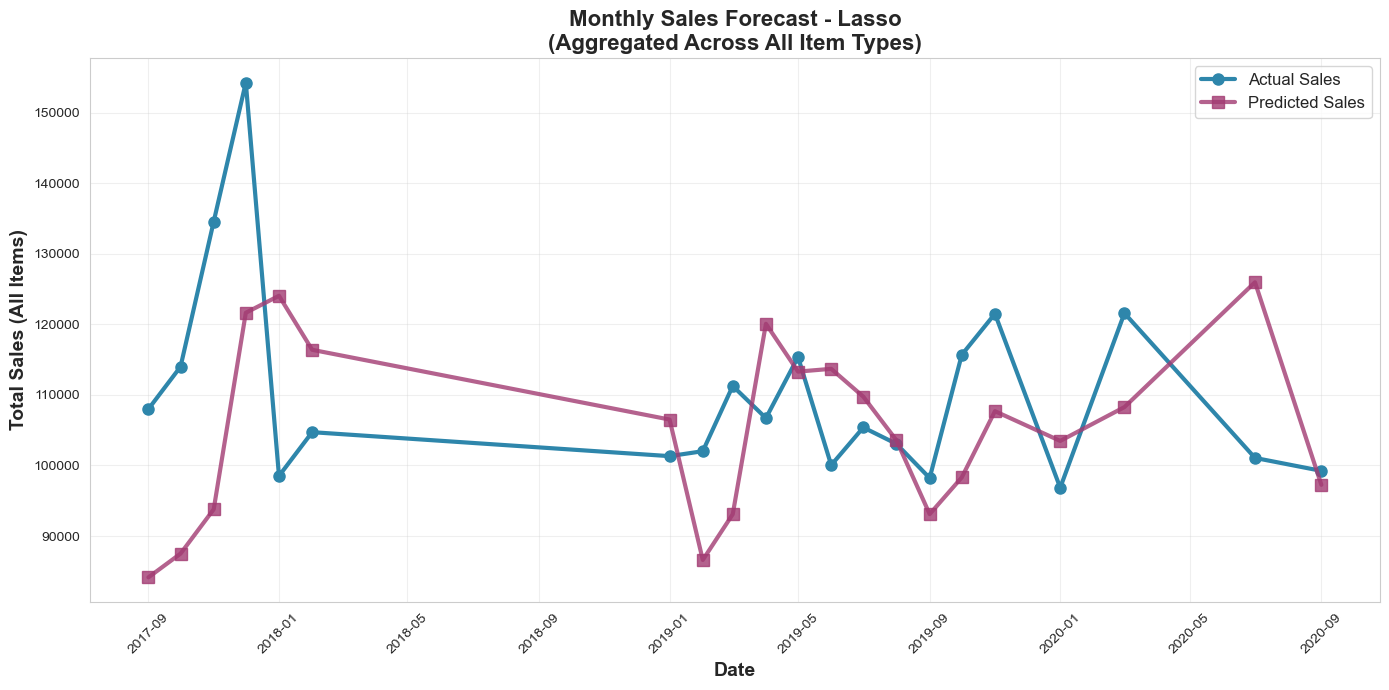

In [ ]:
test_df = df_agg.iloc[split_idx:].copy()
test_df['PREDICTIONS'] = best_predictions

# Aggregate by date (sum all item types per month)
monthly_agg = test_df.groupby('DATE').agg({
    'TOTAL_SALES': 'sum',
    'PREDICTIONS': 'sum'
}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(monthly_agg['DATE'], monthly_agg['TOTAL_SALES'], 
        marker='o', linewidth=3, markersize=8, label='Actual Sales', color='#2E86AB')
ax.plot(monthly_agg['DATE'], monthly_agg['PREDICTIONS'], 
        marker='s', linewidth=3, markersize=8, label='Predicted Sales', 
        color='#A23B72', alpha=0.8)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Sales (All Items)', fontsize=14, fontweight='bold')
ax.set_title(f'Monthly Sales Forecast - {best_model_name}\n(Aggregated Across All Item Types)', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forecast_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

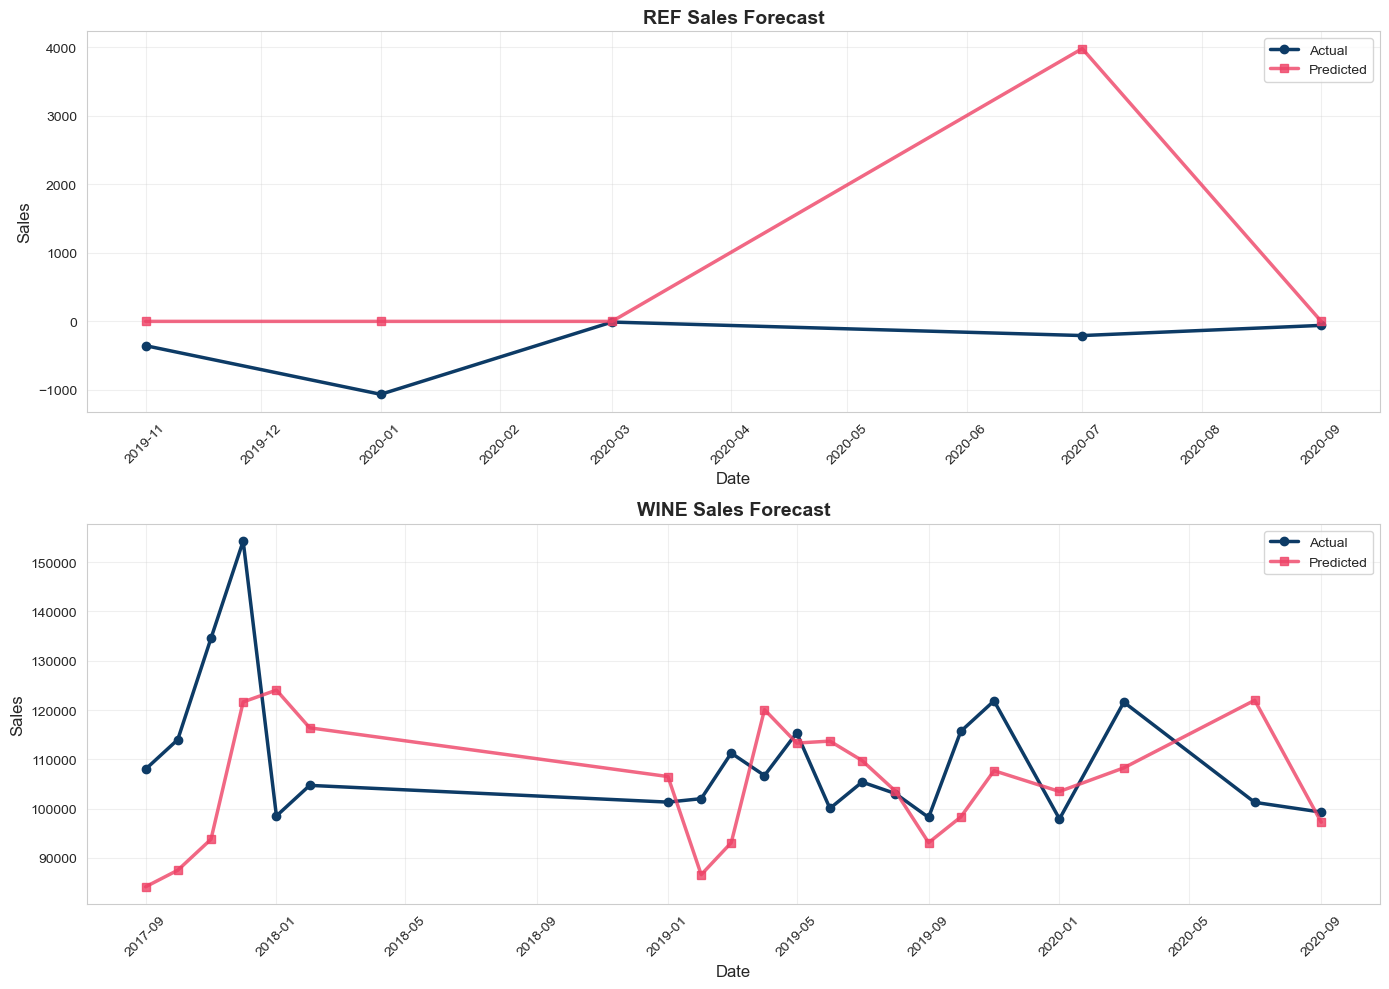

In [ ]:
item_types = test_df['ITEM TYPE'].unique()
n_items = len(item_types)

# Create subplots
fig, axes = plt.subplots(n_items, 1, figsize=(14, 5*n_items))
if n_items == 1:
    axes = [axes]

for idx, item_type in enumerate(item_types):
    item_data = test_df[test_df['ITEM TYPE'] == item_type].sort_values('DATE')
    
    axes[idx].plot(item_data['DATE'], item_data['TOTAL_SALES'], 
                   marker='o', linewidth=2.5, markersize=6, 
                   label='Actual', color='#0D3B66')
    axes[idx].plot(item_data['DATE'], item_data['PREDICTIONS'], 
                   marker='s', linewidth=2.5, markersize=6, 
                   label='Predicted', color='#EE4266', alpha=0.8)
    
    axes[idx].set_title(f'{item_type} Sales Forecast', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=12)
    axes[idx].set_ylabel('Sales', fontsize=12)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('forecast_by_item_type.png', dpi=300, bbox_inches='tight')
plt.show()


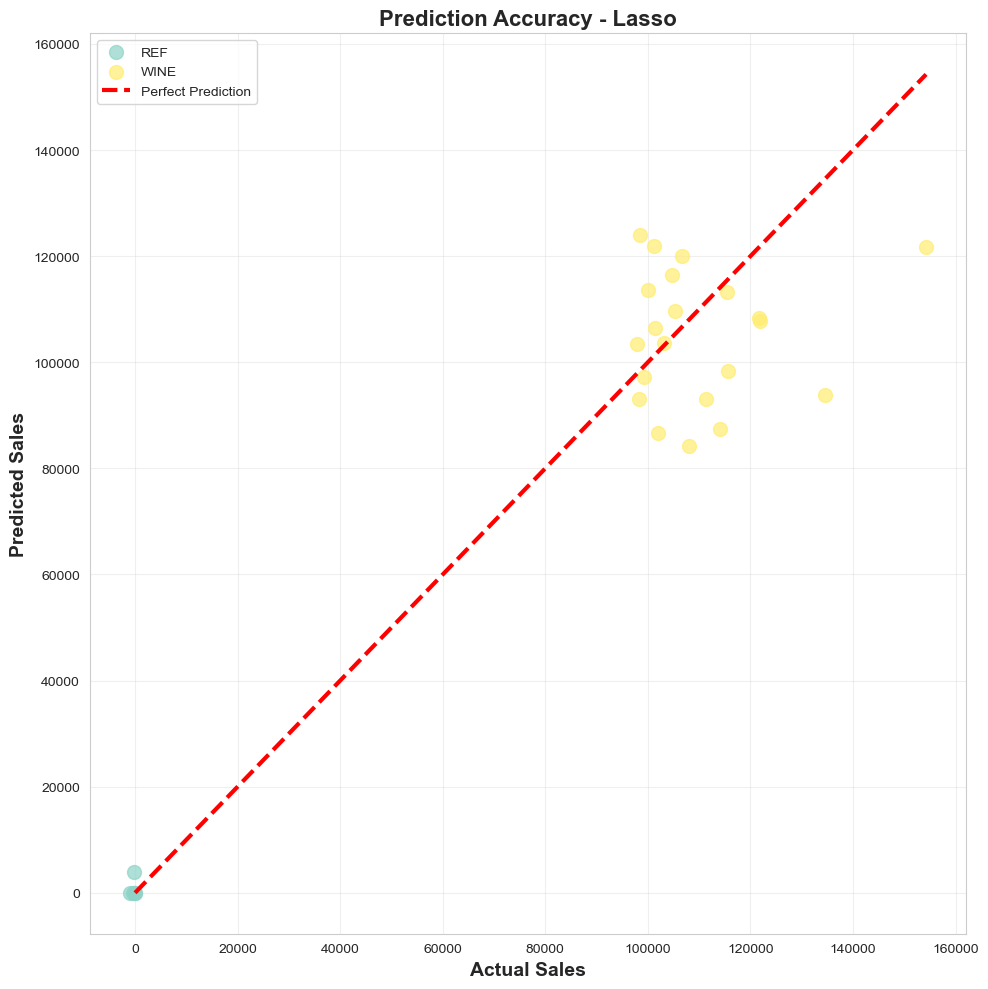

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Color by item type
colors = plt.cm.Set3(np.linspace(0, 1, n_items))
for idx, item_type in enumerate(item_types):
    mask = test_df['ITEM TYPE'] == item_type
    ax.scatter(test_df[mask]['TOTAL_SALES'], 
              test_df[mask]['PREDICTIONS'],
              alpha=0.7, s=100, label=item_type, color=colors[idx])

# Perfect prediction line
max_val = max(test_df['TOTAL_SALES'].max(), test_df['PREDICTIONS'].max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=3, label='Perfect Prediction')

ax.set_xlabel('Actual Sales', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted Sales', fontsize=14, fontweight='bold')
ax.set_title(f'Prediction Accuracy - {best_model_name}', fontsize=16, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

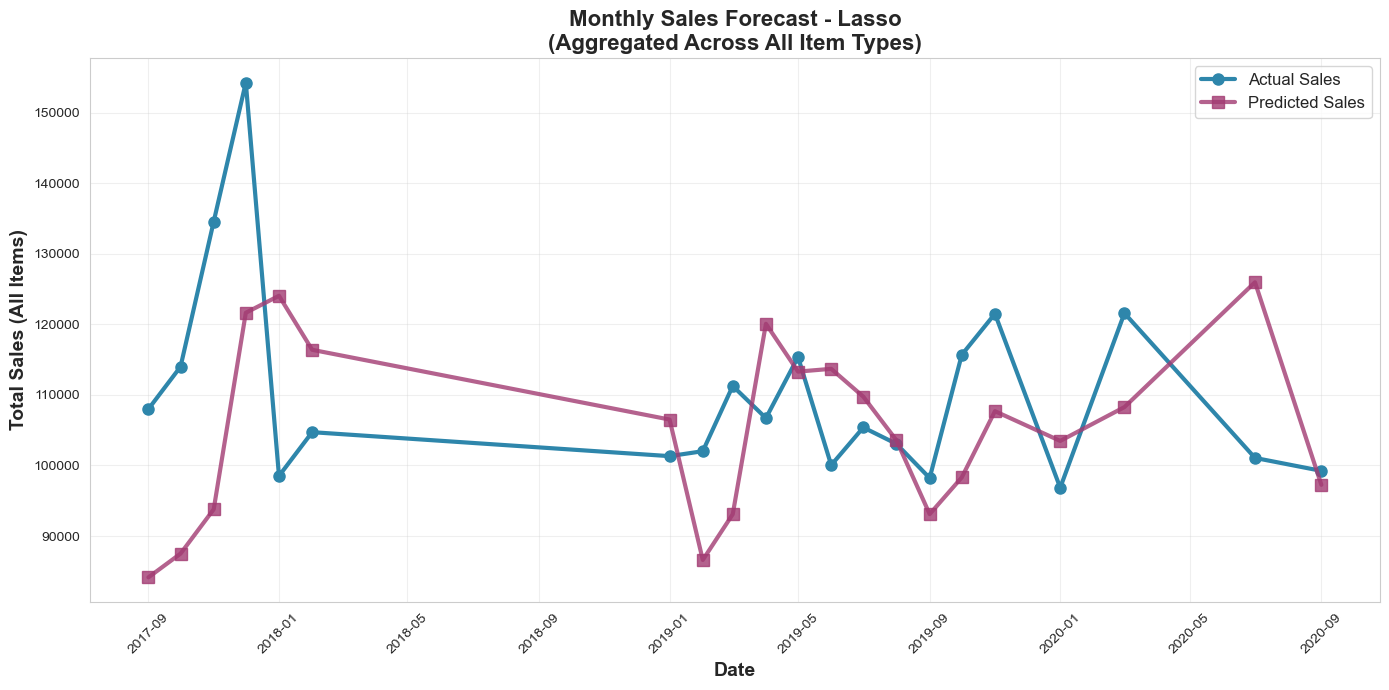

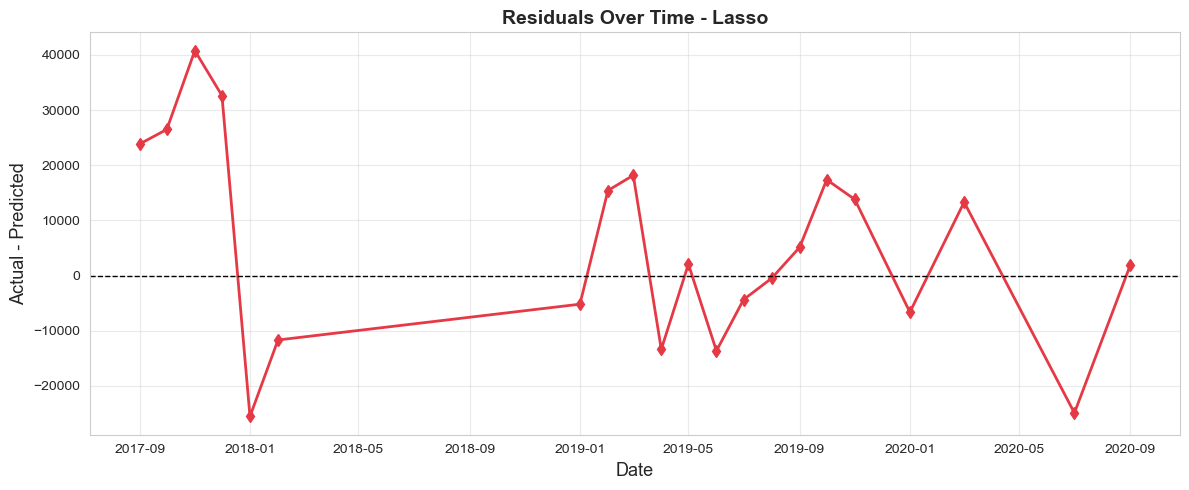

In [ ]:

test_df = df_agg.iloc[split_idx:].copy()

test_df['PREDICTIONS'] = best_predictions

monthly_agg = test_df.groupby('DATE').agg({
    'TOTAL_SALES': 'sum',
    'PREDICTIONS': 'sum'
}).reset_index()

# Plot Actual vs Predicted
fig, ax = plt.subplots(figsize=(14, 7))

# Actual line
ax.plot(monthly_agg['DATE'], monthly_agg['TOTAL_SALES'],
        marker='o', linewidth=3, markersize=8, label='Actual Sales', color='#2E86AB')

# Predicted line
ax.plot(monthly_agg['DATE'], monthly_agg['PREDICTIONS'],
        marker='s', linewidth=3, markersize=8, label='Predicted Sales',
        color='#A23B72', alpha=0.8)


ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Sales (All Items)', fontsize=14, fontweight='bold')
ax.set_title(f'Monthly Sales Forecast - {best_model_name}\n(Aggregated Across All Item Types)',
             fontsize=16, fontweight='bold')


ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
